# 1d profile model with Wickert-Schildgen transport approach

*(May 2022 - version of 5/21)*

This is an attempt to create a 1d version of the Wickert-Schildgen transport model. Along the way, we add on a lateral gravel influx term that depends on height difference between the channel and the adjacent topography in the drainage basin.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class wickgenerator:

    def __init__(self, num_pts=5, dx=1000.0, bankfull_runoff=10.0, init_slope=0.01, D50=0.05, intermit_fac=0.01, k_hack=1 / 3):

        self.x = np.linspace(dx, num_pts * dx, num_pts)
        self.A = k_hack * self.x[:-1]**2
        self.Q = bankfull_runoff * self.A
        self.z = init_slope * (self.x.max() - self.x)
        self._kb = 8.3e-8  # width coef, s / m^1/2
        self.dx = dx
        self.D50 = D50
        self.I = intermit_fac
        self.kQs = 0.041
    
    def run(self, duration):

        pass

    def run_one_step(self, dt):

        self.update_hydraulic_geometry()
        self.update_transport_rate()
    
    def update_hydraulic_geometry(self):

        self.S = -np.diff(self.z) / self.dx
        self.W = self._kb * self.Q * self.S**(7/6) / self.D50**1.5
        self.q = self.Q / self.W
        
    def update_transport_rate(self):
        
        self.Qs = self.I * self.kQs * self.Q * self.S**(7/6)
        self.qs = self.Qs / self.W

Let's just test out some of the basics:

In [3]:
model = wickgenerator()
model.run_one_step(1.0)

Text(0, 0.5, 'Bankfull discharge (cmy)')

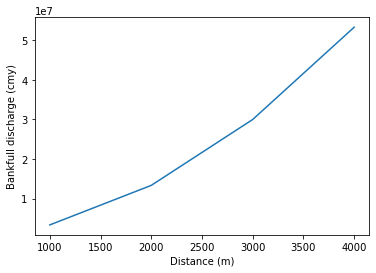

In [4]:
plt.plot(model.x[:-1], model.Q)
model.x
plt.xlabel('Distance (m)')
plt.ylabel('Bankfull discharge (cmy)')

Text(0, 0.5, 'Height (m)')

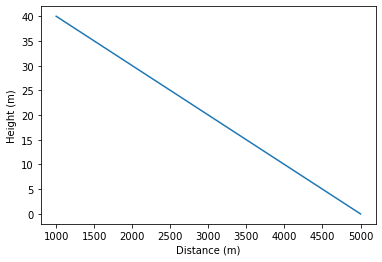

In [5]:
plt.plot(model.x, model.z)
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)')

In [6]:
def model_to_df(model):
    mdf = pd.DataFrame({
        "Slope": model.S,
        "Drainage area (m2)": model.A,
        "Bankfull discharge (cmy)": model.Q,
        "Unit bankfull discharge (m2/y)": model.q,
        "Width (m)": model.W,
        "Gravel flux (cmy)": model.Qs,
        "Unit gravel flux (m2/y)": model.qs
    })
    return mdf

In [8]:
import pandas as pd

In [9]:
mdf = model_to_df(model)
mdf

,Slope,Drainage area (m2),Bankfull discharge (cmy),Unit bankfull discharge (m2/y),Width (m),Gravel flux (cmy),Unit gravel flux (m2/y)
0,0.01,3.333333e+05,3.333333e+06,2.902086e+07,0.114860,6.343505,55.228185
1,0.01,1.333333e+06,1.333333e+07,2.902086e+07,0.459440,25.374019,55.228185
2,0.01,3.000000e+06,3.000000e+07,2.902086e+07,1.033739,57.091543,55.228185
3,0.01,5.333333e+06,5.333333e+07,2.902086e+07,1.837759,101.496076,55.228185


## What's a realistic bankfull runoff rate?

Here are data from a 2020 USGS report on a few NE US streams as an example:

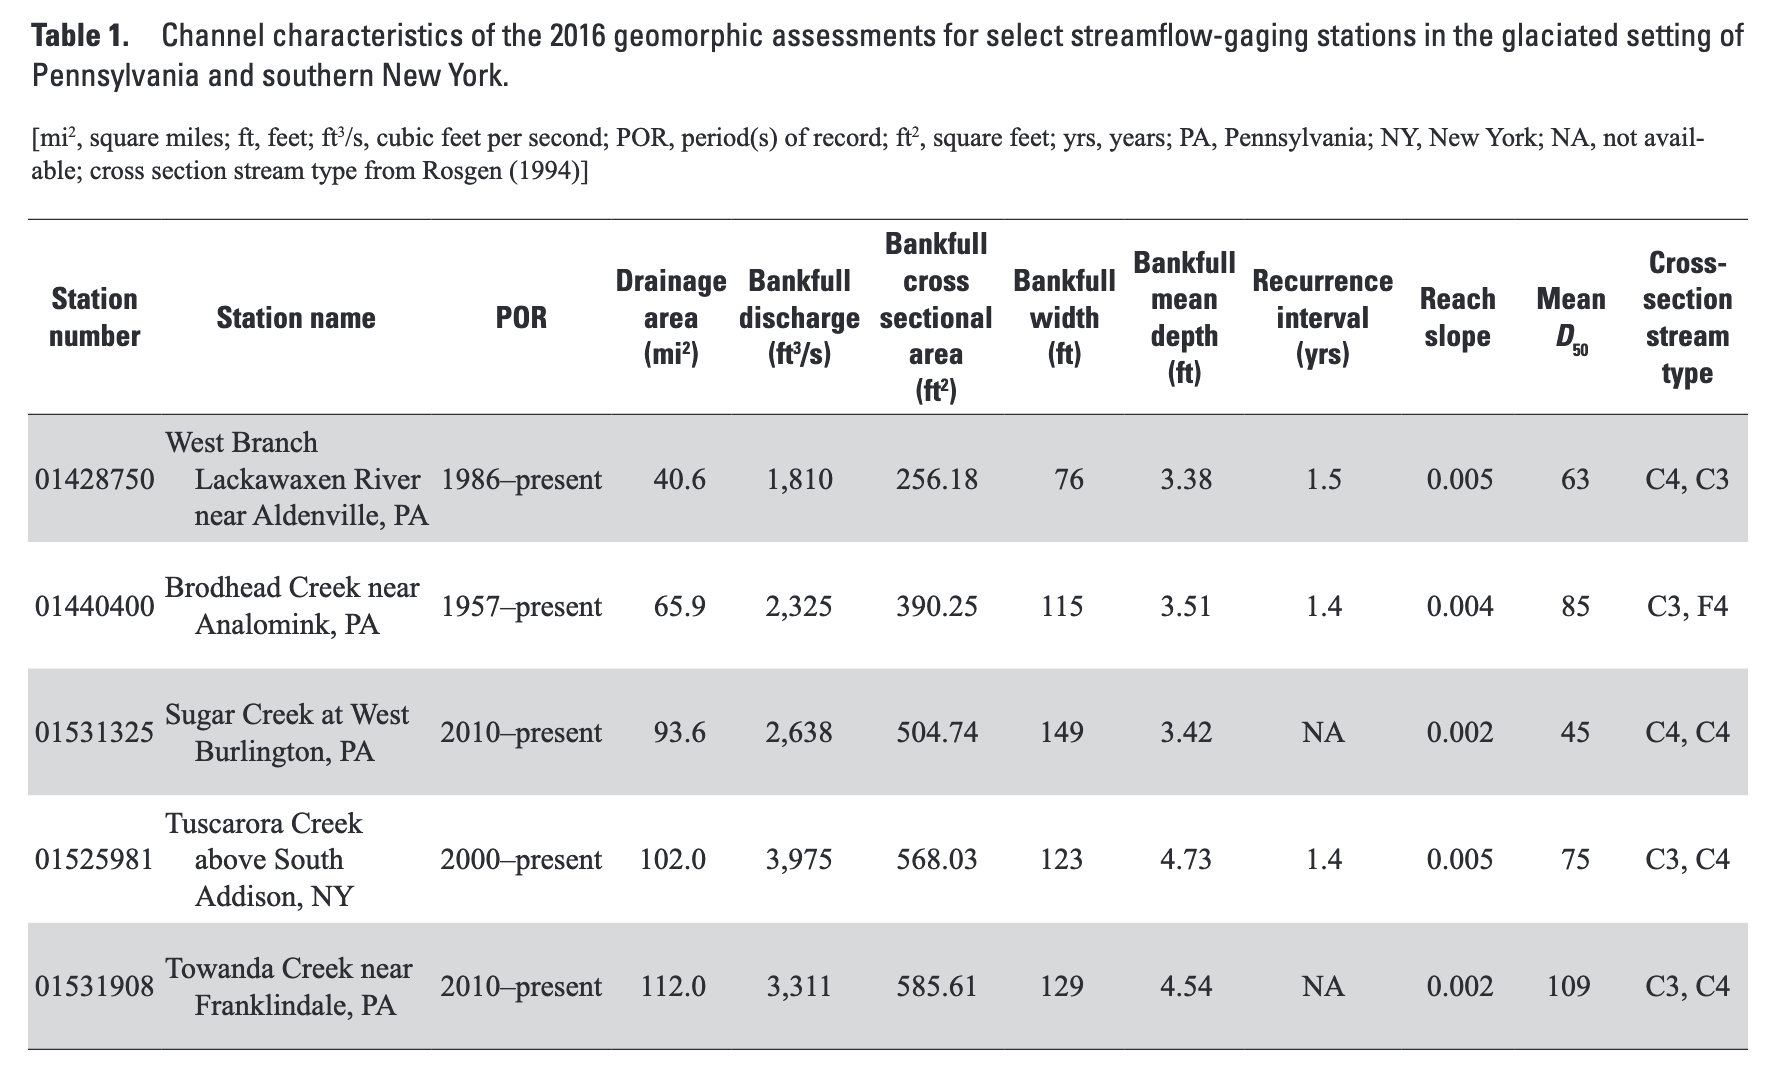

In [10]:
import pandas as pd

df = pd.DataFrame({
    "Drainage area (mi2)" : np.array([40.6, 65.9, 93.6, 102., 112.]),
    "Bankfull discharge (cfs)" : np.array([1810., 2325., 2638., 3975., 3311.])
})

df['Drainage area (m2)'] = df['Drainage area (mi2)'] * 2.58999 * 1e6
df['Bankfull discharge (cms)'] = df['Bankfull discharge (cfs)'] * 0.0283168
df['Bankfull discharge (cmy)'] = df['Bankfull discharge (cms)'] * 3600.0 * 24 * 365.25
df['Bankfull runoff (m/y)'] = df['Bankfull discharge (cmy)'] / df['Drainage area (m2)']

In [11]:
df

,Drainage area (mi2),Bankfull discharge (cfs),Drainage area (m2),Bankfull discharge (cms),Bankfull discharge (cmy),Bankfull runoff (m/y)
0,40.6,1810.0,105153594.0,51.253408,1.617435e+09,15.381638
1,65.9,2325.0,170680341.0,65.836560,2.077644e+09,12.172719
2,93.6,2638.0,242423064.0,74.699718,2.357344e+09,9.724091
3,102.0,3975.0,264178980.0,112.559280,3.552101e+09,13.445811
4,112.0,3311.0,290078880.0,93.756925,2.958744e+09,10.199790


So based on this admittedly small database, a bankfull runoff rate on the order of 10 m/yr is at least realistic.

## Idea of a linear-reservoir lateral sediment supply

How do we deliver sediment from hillslopes and tributaries adjacent to our "main" channel? Here's one possible approach.

Suppose we treat the hillslopes and tributaries around each node as "linear reservoirs", meaning that the flux of sediment to the channel equals the volume of sediment in the "reservoir" times a coefficient with units of inverse time, or

$$Q_L = V / T$$

where $V$ is the "volume" of sediment, which would be equal to the average height of hillslopes above the channel times the width of the basin times the length of the channel segment of interest, and $T$ is our coefficient with units of time. Channel incision would "fill" the reservoir by effectively increasing the volume of sediment that's above the channel.

One way to implement this would be to track the average elevation of "hillslopes and tributaries" adjacent to each channel node. The volume would then be the elevation difference between hill-tribs and channel, times $\Delta x$, times width of the drainage basin at that location. 

Let $z_i$ denote channel elevation at node $i$, and $H_i$ denote the average elevation of hills and tribs adjacent to node $i$. Further, $w_{bi}$ will be the width of the basin at node $i$. Then the "reservoir volume" at node $i$ is

$$V_i = (H_i - z_i) w_{bi} \Delta x$$

The sediment flux from hills+tribs to the channel at $i$ would then be

$$Q_{Li} = \frac{(H_i - z_i) w_{bi} \Delta x}{T}$$

(The $\Delta x$ is ok, because in the conservation equation this will appear as $q_L = Q_L / \Delta x$, i.e., the length of the stream segment will drop out. Also, strictly speaking, this is defined only for $H_i \ge z_i$.)

One complication is that the response time scale $T$ will likely vary with basin width. If we had purely diffusive hillslopes, then $T$ would be proportional to the square of basin width (which would also be hillslope length). But here our basin width is meant to represent a mish-mash of diffusive-like hillslopes, tributary channels, steeper hyper-diffusive (i.e., "nonlinear") hillslopes, etc. So it's hard to generalize about what would govern the response time scale. For the sake of simplicity, how about just asserting that the response time scale is just proportional to the basin width? I can't think of a good symbol for such a coefficient, so let's just use $\psi$ to represent the response time (in years) per unit basin width in meters. So the response time is

$$T(x) = \psi w_b$$

The basin width is equivalent to the rate of increase in drainage area with respect to streamwise distance, $x$, and if we use Hack's law with a power of 2, we get:

$$w_b = \frac{dA}{dx} = \frac{d(k_h x^2)}{dx} = 2 k_h x$$

So from there our time scale becomes

$$T(x) = 2 \psi k_h x$$

In other words, the response time increases linearly downstream. Our unit sediment flux from the basin hills + tribs to the channel would then be:

$$q_L(x) = \frac{V(x)}{T(x)} = \frac{(H(x) - z(x)) w_b(x)}{\psi w_b(x)} = \frac{(H(x) - z(x))}{\psi}$$

The interesting thing here is that basin width cancels, and you end up with the lateral flux depending only on the height difference. If you write this in discrete form for a particular node $i$,

$$Q_{Li} = \frac{(H_i - z_i) \Delta x}{\psi}$$

The units are right because $\psi$ has units of years per meter, so in total it's cubic meters of sediment (gravel) per year. (I suppose you could also have a factor that says what fraction of erosional stuff is gravel sized).

Of course, to pull this off you need an equation for $H(x,t)$. But that's just mass conservation:

$$\frac{\partial H}{\partial t} = -\frac{q_L}{w_b} = -\frac{H-z}{2 \psi k_h x}$$

So it's undefined for $x=0$ (or for that matter $x<0$) but that's ok, we're only interested in streams with a drainage area (and hence, $x>0$).

There's a kind of steady solution that should occur if $dz/dt$ is constant. Let's say $dz/dt = -E$. Subtract this from both sides:

$$\frac{\partial H}{\partial t} - \frac{\partial z}{\partial t} = -\frac{q_L}{w_b} = -\frac{H-z}{2 k_h x} - \frac{\partial z}{\partial t}$$

or

$$\frac{\partial (H-z)}{\partial t} = -\frac{q_L}{w_b} = -\frac{H-z}{2 k_h x} + E$$

This equation should have an exponential solution, just based on its form ($dy/dt = a - b y$), with a time constant that presumably gets bigger with $x$.

What does it look like when $H$ and $z$ are lowering at the same rate $E$? Just solve for $H-z$ when the time derivative of $(H-z)$ is zero:

$$H-z = 2 k_h x E$$

I guess this makes sense. Hills+tribs will be higher when they are (a) eroding faster ($E$), and/or (b) wider ($x$).

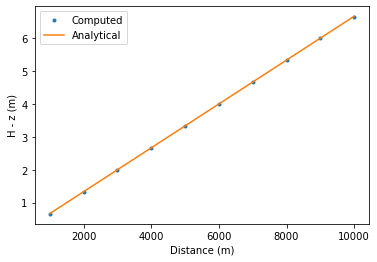

In [12]:
# Code to try this
x = 1000.0 * np.linspace(1, 10, 10)  # steamwise distance, m
kh = 1./3.  # Hack coefficient
A = kh * x**2  # drainage area, m2
psi = 1.0  # response-time coefficient, years per meter
E = 0.001  # lowering rate, m/y
nsteps = 10000
dt = 10.0  # time step, years
z = 1000.0 + np.zeros(len(x))  # stream height, m
H = 1000.0 + np.zeros(len(x))  # adjacent topography avg. height, m

for i in range(nsteps):
    z -= E * dt  # lower the stream
    dHdt = -(H - z) / (2 * psi * kh * x)  # rate of sed loss from adjacent topo, m/yr
    H += dHdt * dt  # update avg elevation of adjacent topo
    
plt.plot(x, H-z, '.')
Hminusz_pred = 2 * kh * x * E  # analytical steady solution
plt.plot(x, Hminusz_pred)
plt.xlabel('Distance (m)')
plt.ylabel('H - z (m)')
plt.legend(['Computed', 'Analytical'])

## Mass conservation

So we now have a kind of 1+ dimensional model. Here's a derivation of mass conservation. Consider a valley segment of width $B$, length $\Delta x$, height $z$, and bulk sediment density $\rho_s$. Time rate of change of mass is:

$$\frac{\partial \rho_s zW\Delta x}{\partial t} = \rho_s \Delta x q_L + \rho_s Q_s(x) - \rho_s Q_s(x+\Delta x)$$

Factor out $\rho_s$ and divide by $\Delta x$:

$$\frac{\partial zB}{\partial t} = q_L - \frac{Q_s(x+\Delta x)-Q_s(x)}{\Delta x}$$

Take the limit as $\Delta x \rightarrow 0$:

$$\frac{\partial zB}{\partial t} = q_L - \frac{\partial Q_s}{\partial x}$$

Valley width, $B$, is an issue. Wickert and Schildgen use a power law,

$$B = k_B x^{P_B}$$

where, if I'm reading their Figure 4 right, a reasonable value for $P_B$ is around 0.25. If you assume $B\ne f(t)$ it simplifies things:

$$\frac{\partial z}{\partial t} = \frac{q_L}{B} - \frac{1}{B}\frac{\partial Q_s}{\partial x}$$

Transport relation:

$$Q_s = k_Q I Q S^{7/6}$$

So this suggests the possibility of a simple numerical algorithm like so:

- Since $B$ is steady in time, calculate it before the loop
- Same with $Q$
- For each time step
  - Update lower boundary (or do uplift)
  - Calculate $S$ from elevations
  - Calculate $Q_s$ from $Q$ and $S$
  - Calculate $q_L$ (or really $Q_L$) from $H$ and $z$ as above
  - Update $z$ from $Q_s$ and $Q_L$
  - Update $H$ from $Q_L$

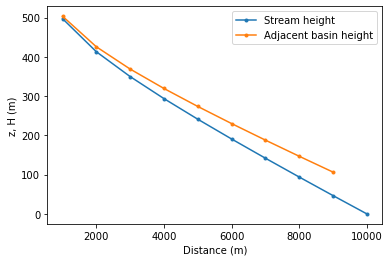

In [13]:
# Code to try this
kh = 1./3.  # Hack coefficient
psi = 100.0  # response-time coefficient, years per meter
U = 0.0001  # baselevel lowering rate, m/y
nsteps = 10000
dt = 1000.0  # time step, years
kB = 79.06  # From W&S
PB = 0.1  # from W&S
runoff = 10.0  # bankfull runoff coefficient, m/yr
dx = 1000.0  # node spacing, m
I = 0.01  # intermittency factor
kQs = 0.041  # transport coefficient

x = dx * np.linspace(1, 10, 10)  # steamwise distance, m

A = kh * x**2  # drainage area, m2
Q = runoff * A  # discharge, cmy
B = kB * x**PB  # valley width, m

z = dx + np.zeros(len(x))  # stream height, m
H = dx + np.zeros(len(x))  # adjacent topography avg. height, m
Qs = np.zeros(len(x))

for i in range(nsteps):
    z[-1] -= U * dt  # lower the baselevel
    S = -np.diff(z) / dx
    Qs[1:] = kQs * I * Q[:-1] * S**(7/6)
    dQsdx = np.diff(Qs) / dx
    qL = (H[:-1] - z[:-1]) / psi  # later influx, m2/y
    dzdt = (qL - dQsdx) / B[:-1]
    z[:-1] += dzdt * dt
    dHdt = -qL / (2 * kh * x[:-1])  # rate of sed loss from adjacent topo, m/yr
    H[:-1] += dHdt * dt  # update avg elevation of adjacent topo
    
plt.plot(x, z, '.-')
plt.plot(x[:-1], H[:-1], '.-')
plt.xlabel('Distance (m)')
plt.ylabel('z, H (m)')
plt.legend(['Stream height', 'Adjacent basin height'])